# Airbnb Data Analysis

David Mao

## Data Analysis

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import seaborn as sns

from libpysal.weights.contiguity import Queen
from libpysal.weights import KNN
from libpysal.cg import KDTree
from splot.esda import plot_moran
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster

from scipy.stats import mannwhitneyu

from collections import Counter

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

For visualizations, we will be using matplotlib and seaborn. For geovisualization, we will be working with the Geopandas package. To spatial data analysis, we will be working with the libpysal and esda packages.

### Dataset Charactistics

We can first load our dataset to see what kinds of data we are working with.

In [2]:
dat = pd.read_csv("Airbnb_NYC_2019.csv")
dat.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
dat.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [4]:
dat.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

###  Geovisualization

Our dataset provides many fields that have to do with location. The latitude and longitude fields describe each rental's map coordinates, neighbourhood_group describes New York City's boroughs, and neighbourhood describes the neighbourhoods.

The first thing to do is create a geographical map of all the rental locations using the coordinates we were given. We first load a map of New York City and its boroughs.

In [5]:
nyc_map = gpd.read_file('nybb_21a')
nyc_map.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,1,Manhattan,361611.823950,6.366038e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
1,2,Bronx,464650.051807,1.187245e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
2,3,Brooklyn,729592.941749,1.934091e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,4,Queens,900087.667191,3.044042e+09,"MULTIPOLYGON (((1032452.015 154469.237, 103245..."
4,5,Staten Island,325956.009000,1.623757e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."


The coordinates in our map look much different than the ones in our data set. This is due to New York City maps use a different projection so we need to change the coordinates in our dataset to the projection used in the map.

In [6]:
geometry = [Point(xy) for xy in zip(dat["longitude"], dat["latitude"])]
geo_df = gpd.GeoDataFrame(dat, crs = 'epsg:4326', geometry = geometry)
geo_df['geometry'] = geo_df['geometry'].to_crs(epsg = 2263)
geo_df['geometry'].head()

0     POINT (991917.303 175175.655)
1     POINT (988746.648 213841.186)
2    POINT (1000333.670 234030.203)
3     POINT (995410.267 188893.967)
4     POINT (999757.550 230200.664)
Name: geometry, dtype: geometry

In [7]:
nyc_map['coords'] = nyc_map['geometry'].apply(lambda x: x.representative_point().coords[:])
nyc_map['coords'] = [coords[0] for coords in nyc_map['coords']]

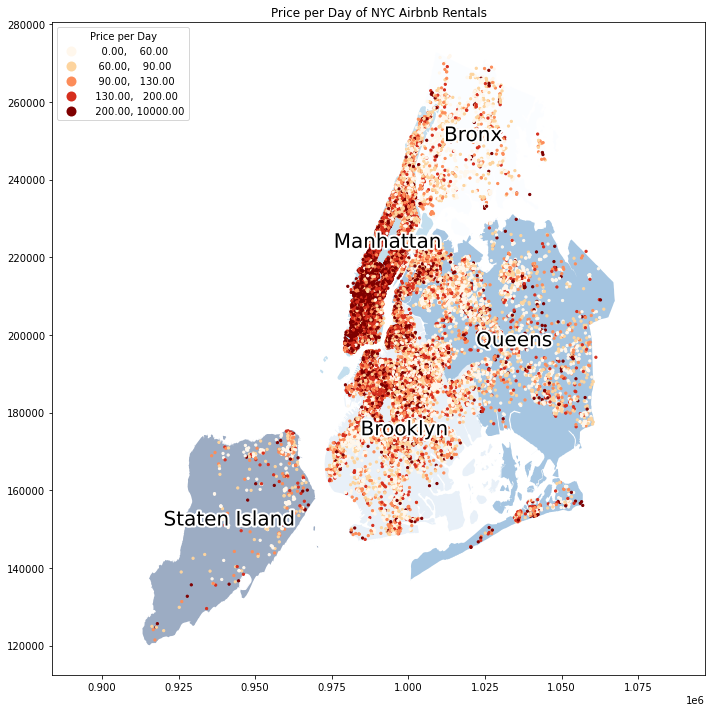

In [8]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Price per Day of NYC Airbnb Rentals')
ax.set_box_aspect(1)
nyc_map.plot(ax=ax, alpha=0.4, column='BoroName', cmap='Blues')
geo_df.plot(ax=ax,
            markersize=5, 
            marker="o", 
            column='price', 
            legend=True, 
            legend_kwds={'loc': 'upper left', 'title': 'Price per Day'},
            cmap='OrRd', 
            scheme='quantiles')
nyc_map.apply(lambda x: ax.annotate(s = x['BoroName'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 20,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);
#fig.savefig('Figure1.jpg')

Text(0.5, 1.0, 'Rental Price per Day < 500')

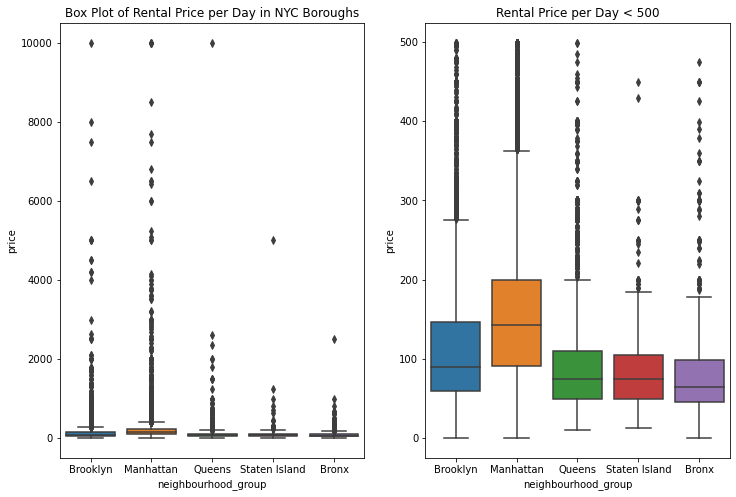

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
sns.boxplot(x = 'neighbourhood_group', 
            y = 'price', 
            data = dat, 
            ax = axes[0]).set_title('Box Plot of Rental Price per Day in NYC Boroughs')
sns.boxplot(x = 'neighbourhood_group', 
            y = 'price', 
            data = dat[dat["price"] < 500], 
            ax = axes[1]).set_title('Rental Price per Day < 500')
#fig.savefig('Figure2.jpg')

In [10]:
dat['neighbourhood'].nunique()

221

In [11]:
nbh = dat['neighbourhood'].unique()
nbh.size

221

In [12]:
nyc_nmap = gpd.read_file('nynta_19d')
nbhmap = nyc_nmap['NTAName'].to_numpy()
nyc_nmap.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK88,Borough Park,39247.227831,5.400502e+07,"POLYGON ((990897.900 169268.121, 990588.252 16..."
1,4,Queens,081,QN51,Murray Hill,33266.904797,5.248828e+07,"POLYGON ((1038593.459 221913.355, 1039369.281 ..."
2,4,Queens,081,QN27,East Elmhurst,19816.712074,1.972685e+07,"POLYGON ((1022728.275 217530.808, 1023052.645 ..."
3,4,Queens,081,QN07,Hollis,20976.335574,2.288777e+07,"POLYGON ((1051539.660 201007.013, 1051920.726 ..."
4,1,Manhattan,061,MN06,Manhattanville,17040.685413,1.064708e+07,"POLYGON ((999174.261 238490.105, 999084.570 23..."


We encounter a problem here. No official maps have the same neighborhood names as the Airbnb dataset. To fix this, we will be assign each listing a new neighborhood name based on the coordinate of the listing. From here on out, we will be using the neighborhood names from our shape map, 'nynta_19d'.

In [13]:
joined_count = gpd.sjoin(nyc_nmap, geo_df, how='inner', op='intersects')
joined_count = joined_count.groupby('NTAName').agg('count').reset_index()
joined_count = nyc_nmap.merge(joined_count[['NTAName', 'id']], how='inner', on='NTAName')

In [14]:
def apply_label(row, x_shift, y_shift):
    ax.annotate(s = row['NTAName'], 
                xy = row.geometry.centroid.coords[0],
                xytext = np.add(row.geometry.centroid.coords[0],(x_shift, y_shift)),
                ha = 'center', 
                color = 'black', 
                fontsize = 12,
                arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3"),
                path_effects = [pe.withStroke(linewidth = 4, foreground = "white")])

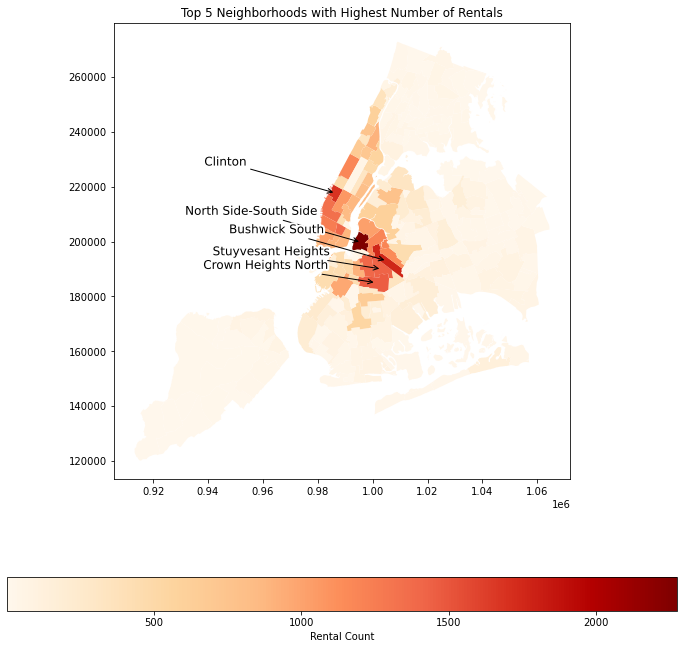

In [15]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Top 5 Neighborhoods with Highest Number of Rentals')
ax.set_box_aspect(1)
joined_count.plot(ax=ax, 
                  column='id', 
                  legend=True, 
                  legend_kwds={'label': "Rental Count",
                              'orientation': "horizontal"},
                  cmap='OrRd')
labels = joined_count.nlargest(5, 'id')
apply_label(labels.iloc[0],-40000,10000)
apply_label(labels.iloc[1],-40000,10000)
apply_label(labels.iloc[2],-40000,10000)
apply_label(labels.iloc[3],-40000,5000)
apply_label(labels.iloc[4],-40000,5000)
#fig.savefig('Figure3.jpg')

In [16]:
tourist_loc = {'location': ['9/11 Memorial',
                           'Metropolitan Museum of Art',
                           'Central Park',
                           'Empire State Building',
                           'Rockefeller Center',
                           'Statue of Liberty',
                           'Broadway',
                           'Times Square',
                           'Madison Square Garden',
                           'Yankee Stadium'],
              'latitude': [980812.311,
                          994441.781,
                          993527.594,
                          988212.237,
                          989929.218,
                          971909.005,
                          991253.149,
                          988267.074,
                          986078.667,
                          1004673.542],
              'longitude': [198495.377,
                           223235.418,
                           223890.852,
                           211939.279,
                           215837.977,
                           190373.715,
                           227419.029,
                           215436.879,
                           212704.122,
                           241531.509]}
tourist_loc = pd.DataFrame(data=tourist_loc)

In [17]:
def apply_label_tourist(row, x_shift, y_shift):
    ax.annotate(s = row['location'], 
                xy = (row['latitude'],row['longitude']),
                xytext = np.add((row['latitude'],row['longitude']),(x_shift, y_shift)),
                ha = 'center', 
                color = 'black', 
                fontsize = 12,
                arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3"),
                path_effects = [pe.withStroke(linewidth = 4, foreground = "white")])

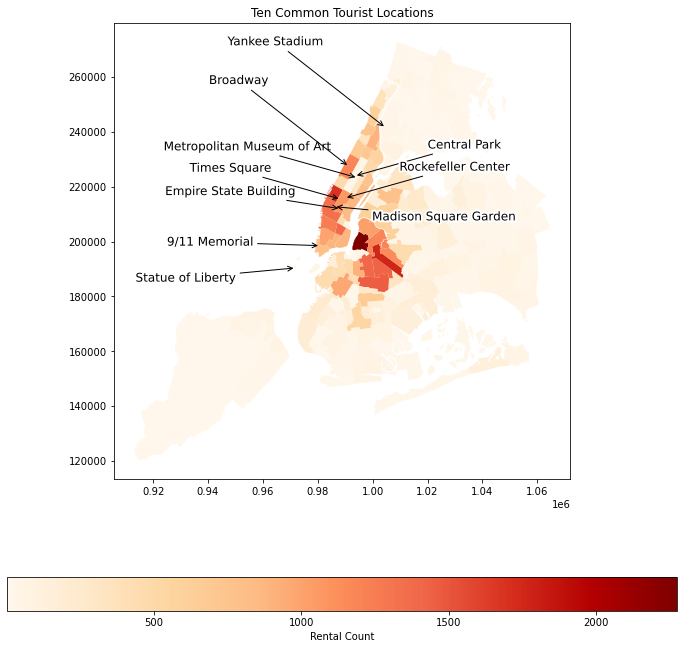

In [18]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Ten Common Tourist Locations')
ax.set_box_aspect(1)
joined_count.plot(ax = ax, 
                  column='id',
                  legend=True, 
                  legend_kwds={'label': "Rental Count",
                              'orientation': "horizontal"},
                  cmap='OrRd')
apply_label_tourist(tourist_loc.iloc[0],-40000,0)
apply_label_tourist(tourist_loc.iloc[1],-40000,10000)
apply_label_tourist(tourist_loc.iloc[2],40000,10000)
apply_label_tourist(tourist_loc.iloc[3],-40000,5000)
apply_label_tourist(tourist_loc.iloc[4],40000,10000)
apply_label_tourist(tourist_loc.iloc[5],-40000,-5000)
apply_label_tourist(tourist_loc.iloc[6],-40000,30000)
apply_label_tourist(tourist_loc.iloc[7],-40000,10000)
apply_label_tourist(tourist_loc.iloc[8],40000,-5000)
apply_label_tourist(tourist_loc.iloc[9],-40000,30000)
#fig.savefig('Figure4.jpg')

In [19]:
joined_price = gpd.sjoin(nyc_nmap, geo_df, how='inner', op='intersects')
joined_price = joined_price.groupby('NTAName').agg('mean').reset_index()
joined_price = nyc_nmap.merge(joined_price[['NTAName', 'price']], how='inner', on='NTAName')

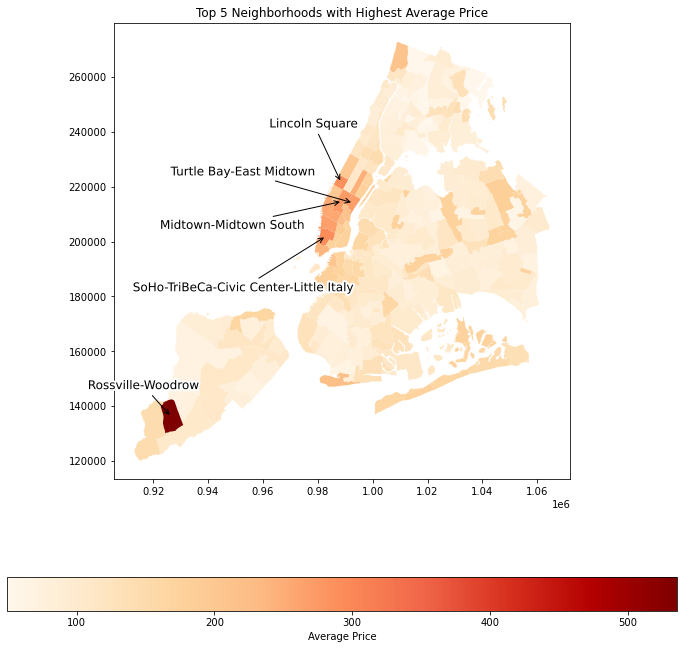

In [20]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Top 5 Neighborhoods with Highest Average Price')
ax.set_box_aspect(1)
joined_price.plot(ax = ax, 
                  column='price', 
                  legend=True,
                  legend_kwds={'label': "Average Price",
                              'orientation': "horizontal"},
                  cmap='OrRd')
labels = joined_price.nlargest(5, 'price')
apply_label(labels.iloc[0],-10000,10000)
apply_label(labels.iloc[1],-30000,-20000)
apply_label(labels.iloc[2],-10000,20000)
apply_label(labels.iloc[3],-40000,-10000)
apply_label(labels.iloc[4],-40000,10000)
#fig.savefig('Figure5.jpg')

In [21]:
joined = gpd.sjoin(nyc_nmap, geo_df, how='inner', op='intersects')
joined[joined['NTAName']=='Rossville-Woodrow'][['id', 'name', 'room_type', 'price', 'reviews_per_month']]

,id,name,room_type,price,reviews_per_month
105,27086249,Anna's place bed and breakfast,Private room,118,NaN
105,34835762,Central Hall Colonial with Free Parking Bus EX...,Entire home/apt,1250,NaN
105,1798271,Spacious center hall colonial,Entire home/apt,700,NaN
105,26258351,Escape NYC in the Borough of Parks!,Entire home/apt,75,1.69


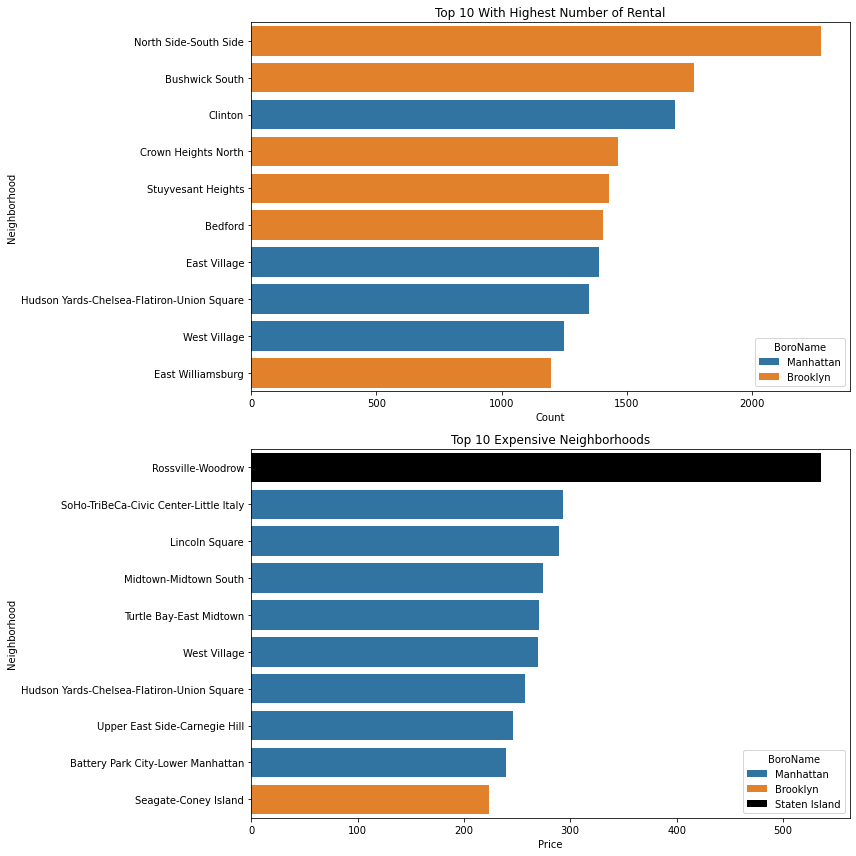

In [22]:
fig, ax = plt.subplots(2, 1, figsize = (12, 12))
sns.barplot(y='NTAName', 
            x='id', 
            data=joined_count.nlargest(10, 'id'),
            hue='BoroName',
            palette=["C0", "C1"],
            hue_order=['Manhattan','Brooklyn'],
            dodge=False,
            ax=ax[0])
ax[0].set(title='Top 10 With Highest Number of Rental', xlabel='Count', ylabel='Neighborhood')
sns.barplot(y='NTAName', 
            x='price', 
            data=joined_price.nlargest(10, 'price'),
            hue='BoroName',
            palette=["C0", "C1", "k"],
            hue_order=['Manhattan','Brooklyn','Staten Island'],
            dodge=False,
            ax=ax[1])
ax[1].set(title='Top 10 Expensive Neighborhoods', xlabel='Price', ylabel='Neighborhood')
fig.tight_layout()
#fig.savefig('Figure6.jpg')

In [23]:
nyc_sub_map = gpd.read_file('nyu_2451_34758')
nyc_sub_map_stations = gpd.read_file('nyu_2451_34760', crs={"init":"EPSG:2263"})

<AxesSubplot:title={'center':'NYC Subway Routes and Routes'}>

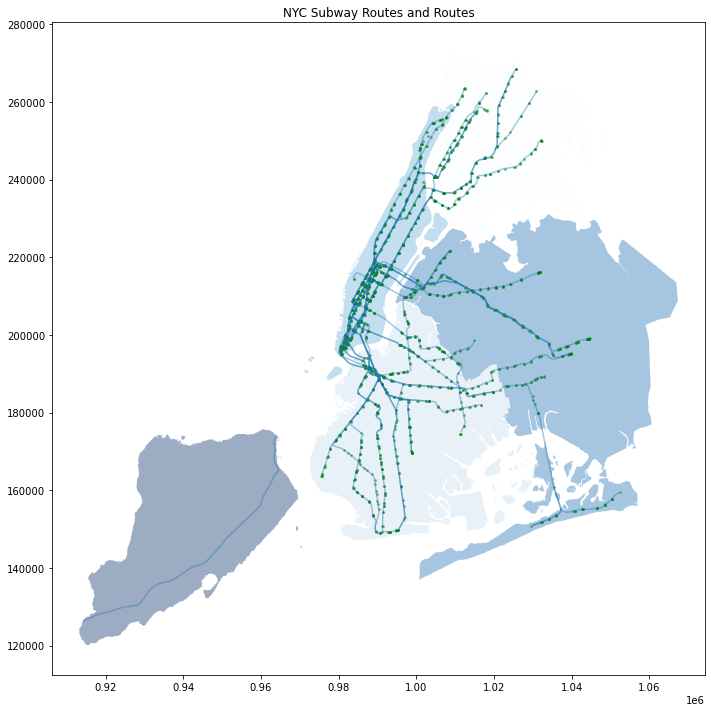

In [24]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='NYC Subway Routes and Routes')
ax.set_box_aspect(1)
nyc_map.plot(ax=ax, alpha=0.4, column='BoroName', cmap='Blues')
nyc_sub_map.plot(ax=ax, alpha=0.4)
nyc_sub_map_stations.plot(ax=ax, alpha=0.4, marker='*', color='green', markersize=5)
#fig.savefig('Figure7.jpg')

Now we would like to find all listings within 100 meters of a subway station. The way we do this is converting our coordinate system to epsg3957, which then the distance between points in this coordinate system denote meters.

In [25]:
nyc_sub_map_stations['geometry']=nyc_sub_map_stations['geometry'].to_crs(epsg=3857)
geo_df['geometry'] = geo_df['geometry'].to_crs(epsg=3857)

In [26]:
x = nyc_sub_map_stations.buffer(100).unary_union

In [27]:
neighbours = geo_df["geometry"].intersection(x)

In [28]:
nyc_sub_map_stations['geometry']=nyc_sub_map_stations['geometry'].to_crs(epsg=2263)
geo_df['geometry'] = geo_df['geometry'].to_crs(epsg=2263)

In [29]:
close_to_station = geo_df[~neighbours.is_empty]
far_to_station = geo_df[neighbours.is_empty]
close_to_station.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188,POINT (986919.676 199202.082)
20,7801,Sweet and Spacious Brooklyn Loft,21207,Chaya,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,3,9,2011-12-28,0.07,1,0,POINT (996119.884 201019.202)
33,9783,back room/bunk beds,32294,Ssameer Or Trip,Manhattan,Harlem,40.82130,-73.95318,Private room,50,3,273,2019-07-01,2.37,3,359,POINT (997208.667 238502.376)
39,12048,LowerEastSide apt share shortterm 1,7549,Ben,Manhattan,Lower East Side,40.71401,-73.98917,Shared room,40,1,214,2019-07-05,1.81,4,188,POINT (987252.320 199409.789)
46,12937,"1 Stop fr. Manhattan! Private Suite,Landmark B...",50124,Orestes,Queens,Long Island City,40.74771,-73.94740,Private room,130,3,248,2019-07-01,2.25,1,215,POINT (998824.533 211691.942)


<AxesSubplot:title={'center':'Price per Day of NYC Airbnb Rentals within 100 Meters of Subway Station'}>

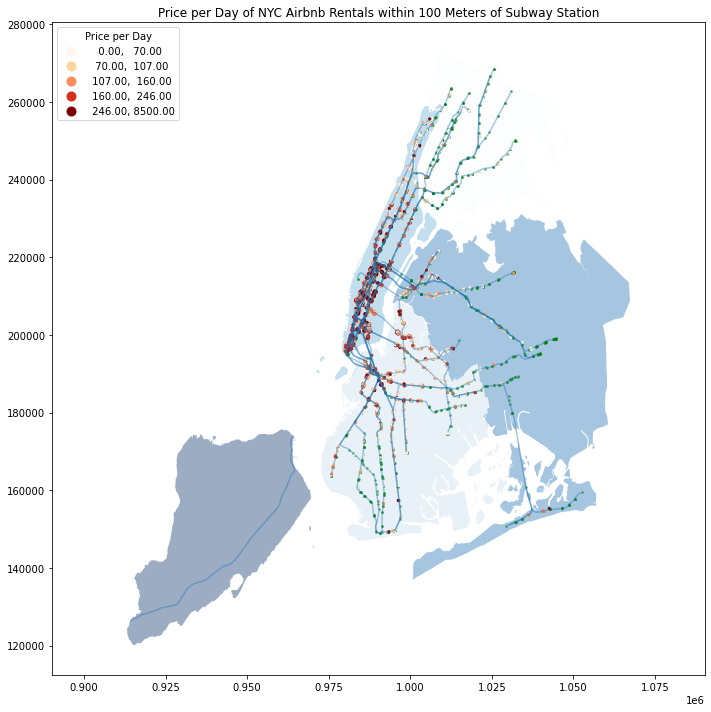

In [30]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Price per Day of NYC Airbnb Rentals within 100 Meters of Subway Station')
ax.set_box_aspect(1)
nyc_map.plot(ax=ax, alpha=0.4, column='BoroName', cmap='Blues')
nyc_sub_map.plot(ax=ax, alpha=0.4)
nyc_sub_map_stations.plot(ax=ax, alpha=0.4, marker='*', color='green', markersize=5)
close_to_station.plot(ax=ax,
            markersize=5, 
            marker="o", 
            column='price', 
            legend=True, 
            legend_kwds={'loc': 'upper left', 'title': 'Price per Day'},
            cmap='OrRd', 
            scheme='quantiles')
#fig.savefig('Figure8.jpg')

In [31]:
close_to_station[close_to_station['price']<500]['price'].mean()

154.13013892826766

In [32]:
far_to_station[far_to_station['price']<500]['price'].mean()

128.1297894999207

Text(0.5, 1.0, 'Prices for listings further than 100 meters of Subway Station')

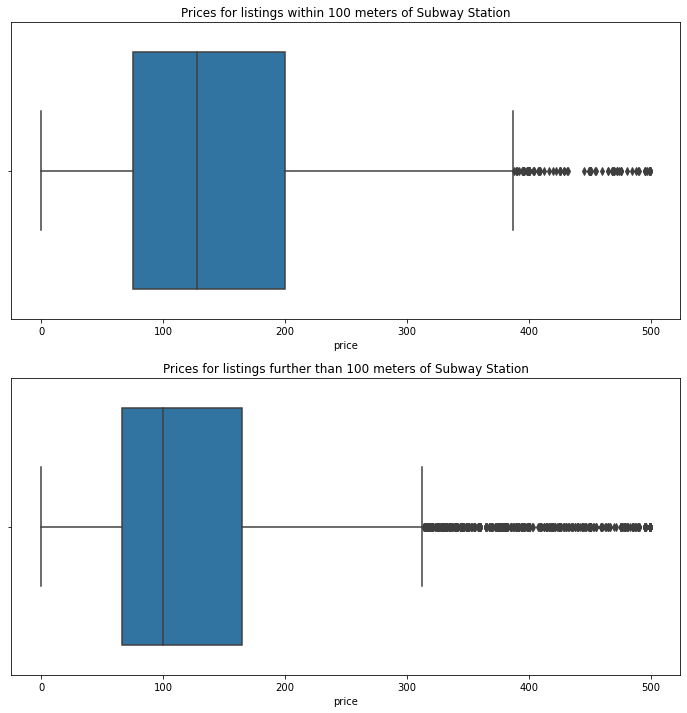

In [33]:
fig, ax = plt.subplots(2, 1, figsize = (12, 12))
sns.boxplot('price', data=close_to_station[close_to_station['price']<500], ax=ax[0]).set_title("Prices for listings within 100 meters of Subway Station")
sns.boxplot('price', data=far_to_station[far_to_station['price']<500], ax=ax[1]).set_title("Prices for listings further than 100 meters of Subway Station")
#fig.savefig('Figure9.jpg')

In [34]:
stat, p = mannwhitneyu(close_to_station[close_to_station['price']<500]['price'], far_to_station[far_to_station['price']<500]['price'])

In [35]:
stat, p

(65880706.0, 1.804587185433989e-52)

### GeoSpatial Analysis

The queen criterion way of finding spatial weights defines neighbors as shapes that share at least one vertex (much like how a queen in chess can move in all directions).

In [36]:
y = joined_price['price'].to_numpy()
w = Queen.from_dataframe(joined_price)
w.transform = 'r'

In [37]:
moran = Moran(y, w)
moran.I

0.4100932485882982

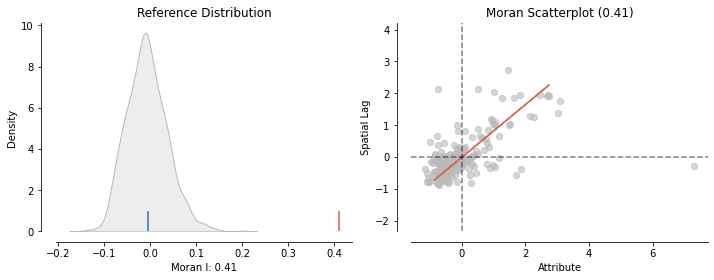

In [38]:
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.tight_layout()
#plt.savefig('Figure10.jpg')

In [39]:
moran.p_sim

0.001

(<Figure size 1152x1152 with 2 Axes>, <AxesSubplot:>)

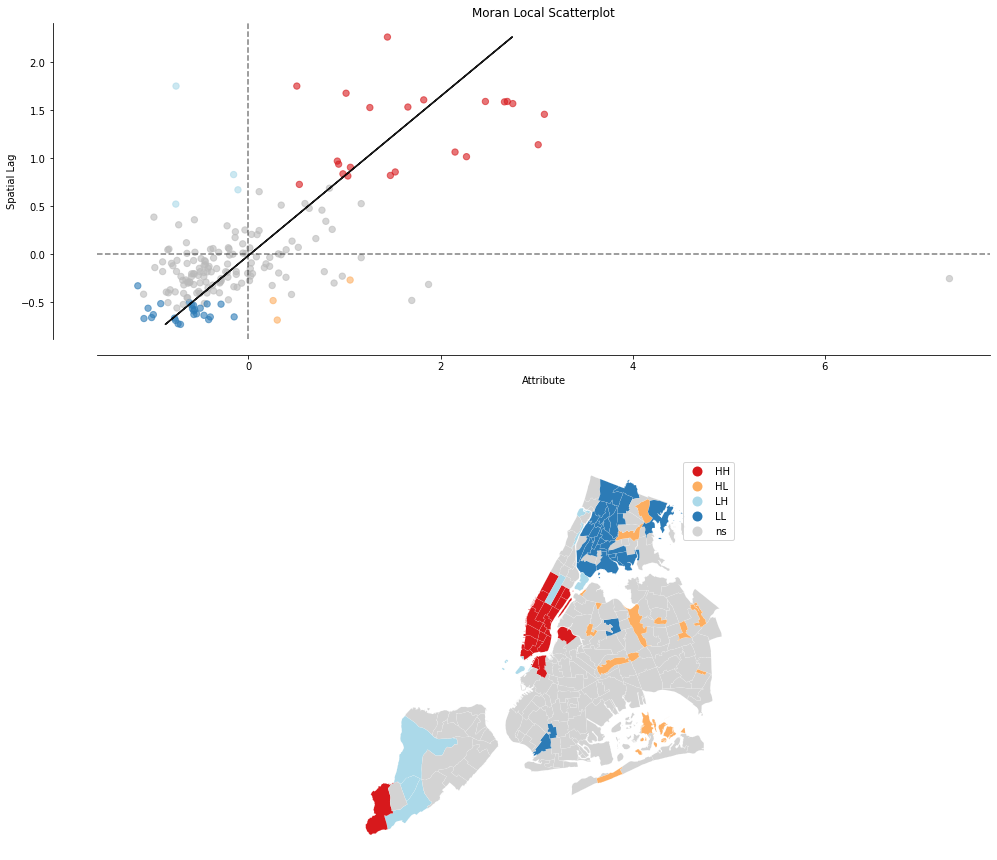

In [40]:
moran_loc = Moran_Local(y, w)
fig, axes = plt.subplots(2, 1, figsize = (16, 16))
moran_scatterplot(moran_loc, p=0.05, ax=axes[0])
lisa_cluster(moran_loc, joined_price, p=0.05, ax=axes[1])
#fig.savefig('Figure11.jpg')

In [41]:
geo_df2 = geo_df[geo_df['price']<500]

In [42]:
list_arrays = [np.array((geom.xy[0][0], geom.xy[1][0])) for geom in geo_df2['geometry']]
list_arrays = np.array(list_arrays)

We will use the KNN method to define two points as neighbors. If a point is the kth closest point or closer, then point two is a neighbor to point one.

In [43]:
kd = KDTree(list_arrays)
wnn2 = KNN(kd, 100)

In [44]:
y = geo_df2['price'].to_numpy()
y = np.log(y+1)

In [45]:
moran = Moran(y, wnn2)
moran.I

0.3145432825326381

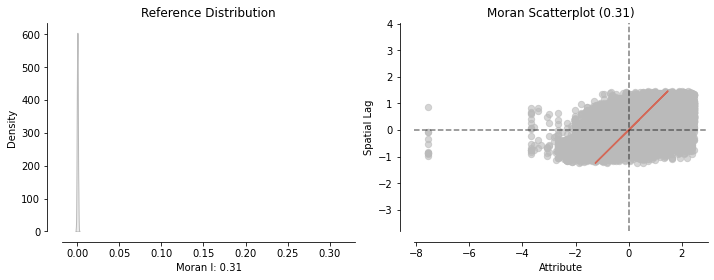

In [46]:
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.tight_layout()
#plt.savefig('Figure12.jpg')

In [47]:
moran.p_sim

0.001

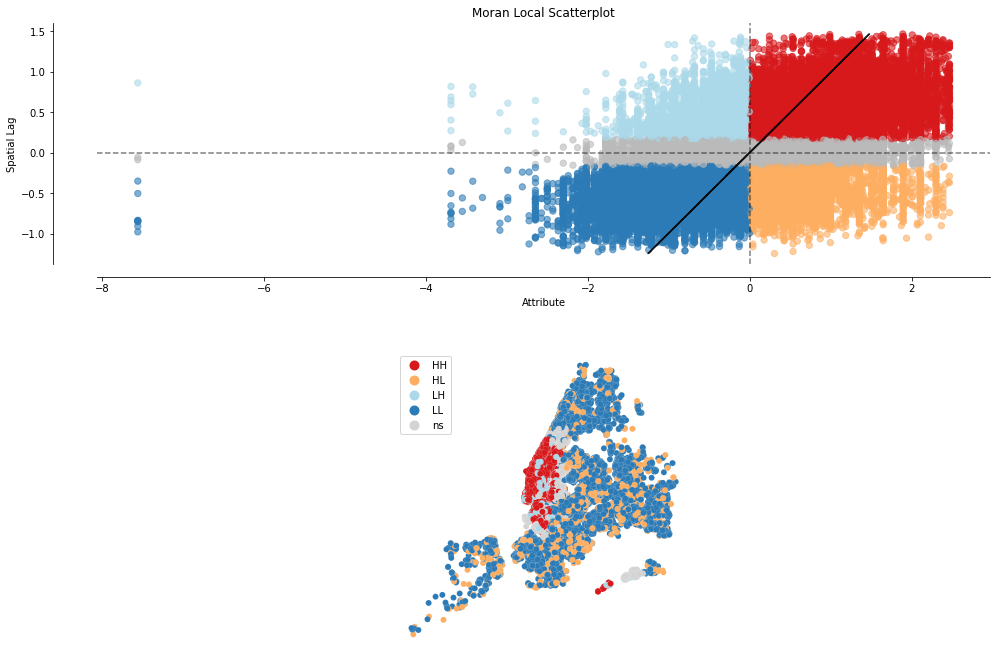

In [48]:
moran_loc = Moran_Local(y, wnn2)
fig, axes = plt.subplots(2, 1, figsize = (16, 12))
axes[1].set_box_aspect(1)
moran_scatterplot(moran_loc, p=0.05, ax=axes[0])
lisa_cluster(moran_loc, geo_df2, p=0.05, ax=axes[1])
axes[1].set_box_aspect(1)
#fig.savefig('Figure13.jpg')

### Analysis on Price

In [49]:
dat["price"].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Histogram of Price < 500')

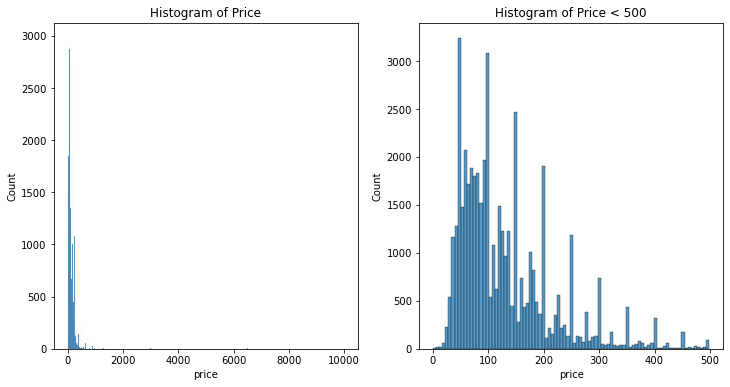

In [50]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.histplot(data=dat, x='price', ax=axes[0]).set_title("Histogram of Price")
sns.histplot(data=dat[dat['price'] < 500], x='price', ax=axes[1]).set_title("Histogram of Price < 500")
#fig.savefig('Figure14.jpg')

In [51]:
high_price = dat[dat["price"] > 500]
high_price.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
85,19601,perfect for a family or small group,74303,Maggie,Brooklyn,Brooklyn Heights,40.69723,-73.99268,Entire home/apt,800,1,25,2016-08-04,0.24,1,7,POINT (986279.780 193296.231)
299,68974,Unique spacious loft on the Bowery,281229,Alicia,Manhattan,Little Italy,40.71943,-73.99627,Entire home/apt,575,2,191,2019-06-20,1.88,1,298,POINT (985283.956 201384.297)
345,89427,The Brooklyn Waverly,116599,Sahr,Brooklyn,Clinton Hill,40.68613,-73.96536,Entire home/apt,650,5,0,NaN,NaN,3,365,POINT (993857.006 189253.989)
365,103311,2 BR w/ Terrace @ Box House Hotel,417504,The Box House Hotel,Brooklyn,Greenpoint,40.73861,-73.95485,Private room,599,3,9,2018-05-19,0.09,28,60,POINT (996761.978 208375.371)
496,174966,Luxury 2Bed/2.5Bath Central Park View,836168,Henry,Manhattan,Upper West Side,40.77350,-73.98697,Entire home/apt,2000,30,30,2018-05-05,0.33,11,0,POINT (987858.986 221083.977)


In [52]:
common_words = Counter(" ".join(high_price["name"]).split()).most_common(20)
common_words

[('in', 206),
 ('Luxury', 100),
 ('2', 96),
 ('Bedroom', 86),
 ('3', 72),
 ('Loft', 72),
 ('-', 70),
 ('with', 66),
 ('of', 60),
 ('NYC', 60),
 ('Suite', 60),
 ('&', 59),
 ('Manhattan', 57),
 ('Village', 56),
 ('Private', 52),
 ('Brooklyn', 51),
 ('Townhouse', 51),
 ('West', 51),
 ('Park', 50),
 ('GUEST', 50)]

In [53]:
common_words = common_words[1:6] + common_words[9:11] + common_words[12:17]
common_words = pd.DataFrame(common_words, columns=['words','count'])
common_words

,words,count
0,Luxury,100
1,2,96
2,Bedroom,86
3,3,72
4,Loft,72
5,NYC,60
6,Suite,60
7,Manhattan,57
8,Village,56
9,Private,52


Text(0.5, 1.0, 'Histogram of Room Type for Price>500')

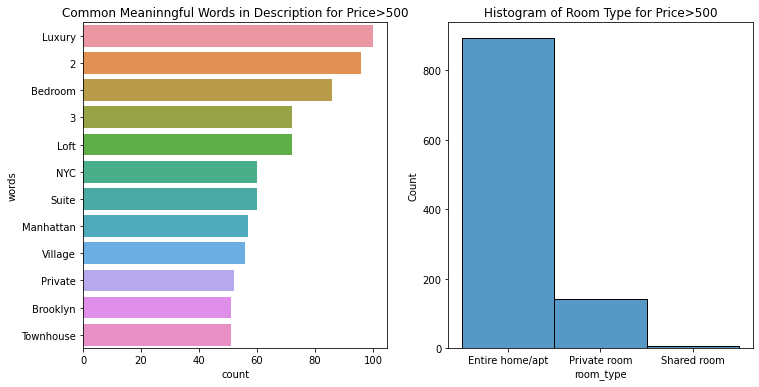

In [54]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.barplot(x='count', 
            y='words', 
            data=common_words, 
            ax=axes[0]).set_title("Common Meaninngful Words in Description for Price>500")
sns.histplot(x='room_type', 
             data=high_price, 
             ax=axes[1]).set_title("Histogram of Room Type for Price>500")
#fig.savefig('Figure15.jpg')

In [55]:
zero_price = dat[dat["price"] == 0]
zero_price

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28,POINT (996929.137 190749.148)
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127,POINT (1015608.788 242767.361)
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0,POINT (1005233.515 192372.525)
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0,POINT (1000681.136 203280.711)
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73,POINT (999096.521 197362.962)
25794,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,2019-06-15,4.28,6,176,POINT (1008263.549 187660.910)
25795,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,2019-06-21,4.37,6,232,POINT (1008740.213 188047.574)
25796,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,2019-06-23,4.35,6,222,POINT (1008424.108 187970.749)
26259,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,NaN,NaN,1,0,POINT (990907.970 212854.342)
26841,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,2019-06-22,0.11,6,333,POINT (1010123.358 191444.558)


## Reviews

NaN review values seem to correspond to no reviews.

In [56]:
dat_review = dat[['number_of_reviews', 'last_review', 'reviews_per_month']]
dat_review_null = dat_review[dat_review.isnull().any(axis=1)]
dat_review_null

,number_of_reviews,last_review,reviews_per_month
2,0,NaN,NaN
19,0,NaN,NaN
26,0,NaN,NaN
36,0,NaN,NaN
38,0,NaN,NaN
...,...,...,...
48890,0,NaN,NaN
48891,0,NaN,NaN
48892,0,NaN,NaN
48893,0,NaN,NaN


In [57]:
all(dat_review_null['number_of_reviews'] == 0)

True

In [58]:
dat['reviews_per_month'] = dat['reviews_per_month'].fillna(0)
dat['last_review'] = pd.to_datetime(dat['last_review'], format="%Y-%m-%d")
dat['last_review'] = dat['last_review'].fillna(min(dat['last_review']))
max_date = max(dat['last_review'])
dat['last_review'] = dat['last_review'].apply(lambda x: max_date.toordinal() - x.toordinal())

In [59]:
dat_review = dat[['number_of_reviews', 'reviews_per_month', 'last_review', 'price']]
dat_review.describe()

,number_of_reviews,reviews_per_month,last_review,price
count,48895.000000,48895.000000,48895.000000,48895.000000
mean,23.274466,1.090910,841.678331,152.720687
std,44.550582,1.597283,1169.872743,240.154170
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.040000,19.000000,69.000000
50%,5.000000,0.370000,186.000000,106.000000
75%,24.000000,1.580000,1201.000000,175.000000
max,629.000000,58.500000,3024.000000,10000.000000


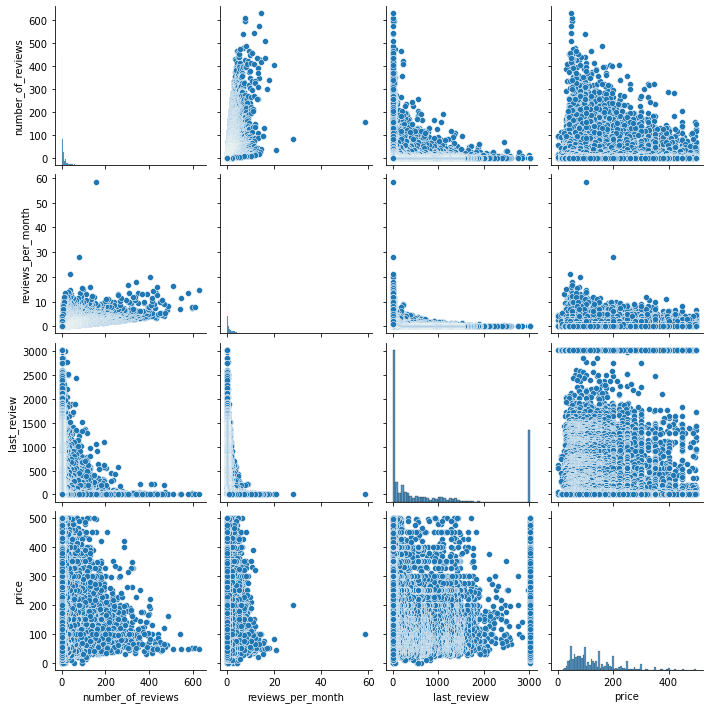

In [60]:
sns.pairplot(dat_review[dat_review['price']<500])
#plt.savefig('Figure16.jpg')

In [61]:
dat_review[dat_review['price']<500].corr()

,number_of_reviews,reviews_per_month,last_review,price
number_of_reviews,1.000000,0.590527,-0.337129,-0.045548
reviews_per_month,0.590527,1.000000,-0.458221,-0.047769
last_review,-0.337129,-0.458221,1.000000,0.064750
price,-0.045548,-0.047769,0.064750,1.000000


In [62]:
high_review = dat[dat['number_of_reviews']>400]

In [63]:
common_words = Counter(" ".join(high_review["name"]).split()).most_common(20)
common_words

[('Room', 14),
 ('Manhattan', 7),
 ('JFK', 7),
 ('Home', 6),
 ('in', 6),
 ('LGA', 6),
 ('&', 5),
 ('near', 5),
 ('PRIVATE', 4),
 ('Private', 4),
 ('Bedroom', 4),
 ('Family', 4),
 ('Airport', 4),
 ('NO', 4),
 ('CLEANING', 4),
 ('FEE', 4),
 ('from', 4),
 ('LaGuardia', 4),
 ('East', 3),
 ('Village', 3)]

In [64]:
common_words = common_words[0:4] + common_words[5:6] + common_words[7:16] + common_words[17:18]
common_words = pd.DataFrame(common_words, columns=['words','count'])
common_words

,words,count
0,Room,14
1,Manhattan,7
2,JFK,7
3,Home,6
4,LGA,6
5,near,5
6,PRIVATE,4
7,Private,4
8,Bedroom,4
9,Family,4


Text(0.5, 1.0, 'Histogram of Price for Reviews>400')

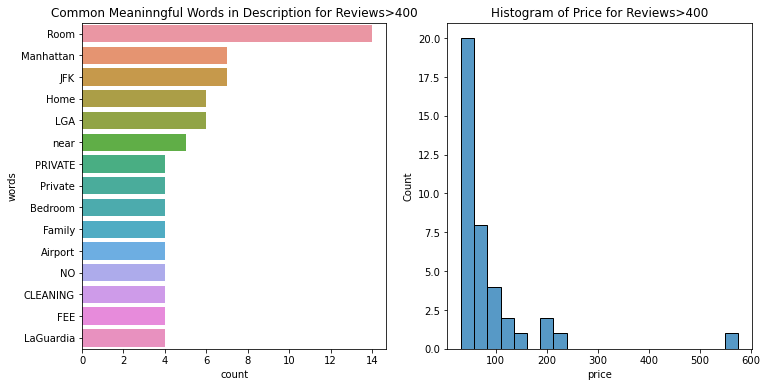

In [65]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.barplot(x='count', 
            y='words', 
            data=common_words, 
            ax=axes[0]).set_title("Common Meaninngful Words in Description for Reviews>400")
sns.histplot(x='price', 
             data=high_review, 
             ax=axes[1]).set_title("Histogram of Price for Reviews>400")
#fig.savefig('Figure17.jpg')

In [66]:
high_review['price'].describe()

count     39.000000
mean      88.871795
std       92.041232
min       32.000000
25%       48.000000
50%       55.000000
75%       92.000000
max      575.000000
Name: price, dtype: float64

### Room Type, Minimum Number of Nights, and Availability

Text(0.5, 1.0, 'Histogram of Minimum Nights <50')

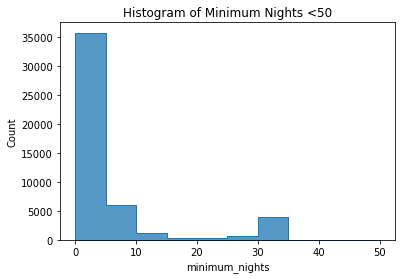

In [67]:
sns.histplot(x='minimum_nights', 
             data=dat, 
             element='step', 
             binrange=(0,50), 
             binwidth=5).set_title("Histogram of Minimum Nights <50")
#plt.savefig('Figure18.jpg')

Text(0.5, 1.0, 'Histagram of Availability of at Least One Day')

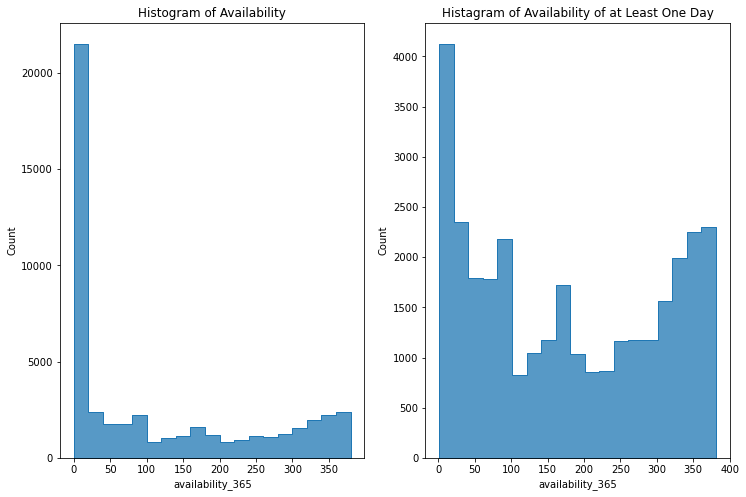

In [68]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
sns.histplot(x='availability_365', 
             data=dat, 
             element='step', 
             binwidth=20, 
             ax = axes[0]).set_title("Histogram of Availability")
sns.histplot(x='availability_365', 
             data=dat[dat['availability_365']>0], 
             element='step', 
             binwidth=20, 
             ax = axes[1]).set_title("Histagram of Availability of at Least One Day")
#fig.savefig('Figure19.jpg')

In [69]:
perc_one = np.zeros(18)
for i in range(17):
    avail = dat[(dat['availability_365']>=i*20) & (dat['availability_365']<i*20+20)]
    perc_one[i] = sum(avail['calculated_host_listings_count']==1)/len(avail)
avail = dat[(dat['availability_365']>=340) & (dat['availability_365']<366)]
perc_one[17]=sum(avail['calculated_host_listings_count']==1)/len(avail)
perc_one

array([0.83502904, 0.69662921, 0.65470852, 0.62162162, 0.63340757,
       0.56879607, 0.57762777, 0.55133736, 0.56265664, 0.56481481,
       0.53035936, 0.51428571, 0.49084568, 0.53026197, 0.47560976,
       0.4       , 0.3496682 , 0.37674619])

In [70]:
dat_range = []
for i in range(18):
    dat_range.append(str(i*20)+' to '+str(i*20+19)+' days')
dat_range[17]= str(340)+' to '+str(365)+' days'

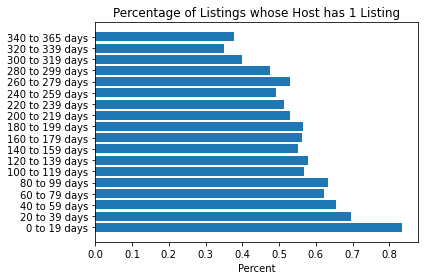

In [71]:
plt.barh(dat_range, perc_one)
plt.title('Percentage of Listings whose Host has 1 Listing')
plt.xlabel('Percent')
plt.tight_layout()
#plt.savefig('Figure20.jpg')

Text(0.5, 1.0, 'Rental Price per Day < 500')

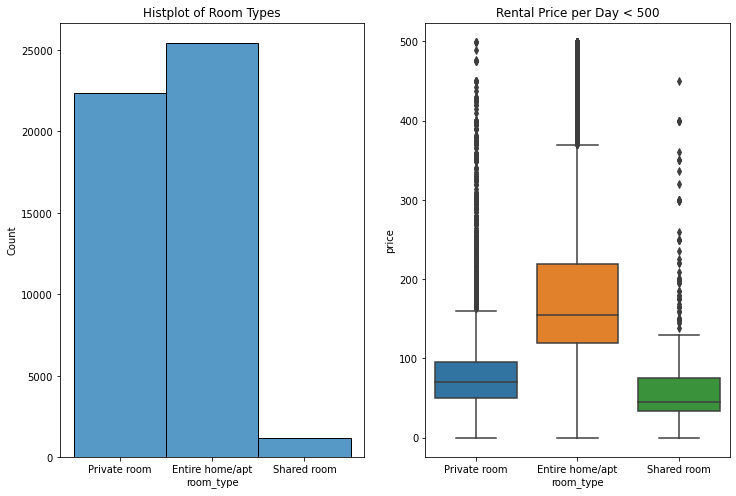

In [72]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
sns.histplot(x = 'room_type', 
            data = dat, 
            ax = axes[0]).set_title('Histplot of Room Types')
sns.boxplot(x = 'room_type', 
            y = 'price', 
            data = dat[dat["price"] < 500], 
            ax = axes[1]).set_title('Rental Price per Day < 500')
#fig.savefig('Figure21.jpg')

In [73]:
df1=dat.groupby(['availability_365', 'room_type']).mean().reset_index()[['availability_365', 'room_type', 'price']]
df1

,availability_365,room_type,price
0,0,Entire home/apt,187.940739
1,0,Private room,82.832078
2,0,Shared room,82.195946
3,1,Entire home/apt,166.841463
4,1,Private room,73.845161
...,...,...,...
960,364,Private room,126.229167
961,364,Shared room,96.733333
962,365,Entire home/apt,427.441237
963,365,Private room,160.133627


Text(0.5, 1.0, 'Shared Room')

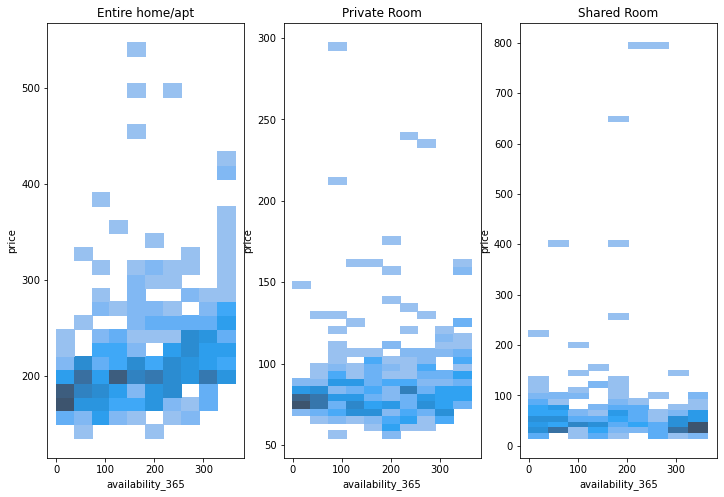

In [74]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
sns.histplot(x='availability_365',
            y='price',
            data=df1[df1['room_type']=='Entire home/apt'],
            ax=axes[0]).set_title("Entire home/apt")
sns.histplot(x='availability_365',
            y='price',
            data=df1[df1['room_type']=='Private room'],
            ax=axes[1]).set_title("Private Room")
sns.histplot(x='availability_365',
            y='price',
            data=df1[df1['room_type']=='Shared room'],
            ax=axes[2]).set_title("Shared Room")
#fig.savefig('Figure22.jpg')

In [75]:
df1[df1['room_type']=='Entire home/apt']

,availability_365,room_type,price
0,0,Entire home/apt,187.940739
3,1,Entire home/apt,166.841463
6,2,Entire home/apt,183.270588
9,3,Entire home/apt,164.250000
12,4,Entire home/apt,165.763975
...,...,...,...
950,361,Entire home/apt,321.969697
953,362,Entire home/apt,374.931034
956,363,Entire home/apt,280.096774
959,364,Entire home/apt,407.190678


References:

https://www.tripadvisor.com/Attractions-g60763-Activities-New_York_City_New_York.html

https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm

https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-cluster-and-outlier-analysis-anselin-local-m.htm